In [1]:
import torch
import numpy as np
import pandas as pd

import sklearn.utils
import sklearn.gaussian_process
import matplotlib.pyplot as plt

In [2]:
class One_D_Datasets(torch.utils.data.Dataset):
    """
    Dataset of one-dimensional functions, generated from varying gaussian processes for testing my NPR methods

    Parameters
    ----------
    num_samples: how many samples from family to collect

    n_same_samples: how many samples to collect with the same hyper-parameters

    n_points: how many points to to sample the process at within range, X

    min_max: tuple, min_max x range to evaluate the gaussian process at

    kernel: kernels for gaussian process regression. Can be ['RBF()', 'ConstantKernel()', 'DotProduct()', 'ExpSineSquared()', 'Matern()', 'WhiteKernel()']

    vary_kernel_hyp: do we vary kernel hyperparameters or nah?
    
    **kwargs: additional arguments to GaussianProcessRegressor
    """
    def __init__(self,
                 num_samples = 10000,
                 n_same_samples = 20,
                 n_points =      128,
                 min_max  =   (-2,2),
                 kernel   = sklearn.gaussian_process.kernels.RBF(length_scale = 0.4, length_scale_bounds = (0.01,1)),
                 vary_kernel_hyp = True,
                 **kwargs
    ):
        super().__init__()
        self.n_points = n_points
        self.num_samples = num_samples
        self.n_same_samples = n_same_samples
        self.min_max = min_max
        self.is_vary_kernel_hyp = vary_kernel_hyp

        if not vary_kernel_hyp:
            # only fit hyperparam when predicting if using various hyperparam
            kwargs["optimizer"] = None

            # we also fix the bounds as these will not be needed
            for hyperparam in kernel.hyperparameters:
                kernel.set_params(**{f"{hyperparam.name}_bounds": "fixed"})

        self.generator = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel, alpha=0.005, **kwargs)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def vary_kernel_hyperparam(self):
        K = self.generator.kernel
        for hyperparam in K.hyperparameters:
            K.set_params(
                **{hyperparam.name: np.random.uniform(*hyperparam.bounds.squeeze())}
            )

    def get_samples(
        self,
        n_samples,
        test_min_max,
        n_points
    ):
        test_min_max = test_min_max if test_min_max is not None else self.min_max
        n_points = n_points if n_points is not None else self.n_points
        n_samples = n_samples if n_samples is not None else self.num_samples
        """
        n_samples: number of samples to generate data for
        test_min_max: range of x values to generate sample for
        n_points: number of points to generate 
        """
        X = self._sample_features(test_min_max, n_points, n_samples)

        self.data, self.targets = self._sample_targets(X, n_samples)

        return self.data, self.targets
        

    def _sample_features(self, min_max, n_points, n_samples):
        X = np.random.uniform(min_max[1], min_max[0], size=(n_samples, n_points))
        X.sort(axis=-1)
        return X

    def _sample_targets(self, X, n_samples):
        targets = X.copy()
        n_samples, n_points = X.shape
        for i in range(0, n_samples, self.n_same_samples):
            if self.is_vary_kernel_hyp:
                self.vary_kernel_hyperparam()
            for attempt in range(self.n_same_samples):
                try:
                    n_same_samples = targets[i:i+self.n_same_samples,:].shape[0]
                    targets[i:i+self.n_same_samples,:] = self.generator.sample_y(
                        X[i+attempt,:,np.newaxis],
                        n_samples = n_same_samples,
                        random_state = None,
                    ).transpose(1,0)
                    X[i:i+self.n_same_samples,:] = X[i+attempt,:]
                except np.linalg.LinAlgError:
                    continue
                else:
                    break
        X, targets = sklearn.utils.shuffle(X, targets)
        targets = torch.from_numpy(targets)
        targets = targets.view(n_samples, n_points, 1).float()
        return X, targets
            
        
            
                 

In [3]:
test_one_d_datasets = One_D_Datasets()

In [4]:
test_one_d_datasets.get_samples(None, None, None)

(array([[-1.96659192, -1.95823913, -1.94002728, ...,  1.90883983,
          1.91616704,  1.96841165],
        [-1.98857369, -1.9755324 , -1.969749  , ...,  1.90353443,
          1.92619431,  1.93271313],
        [-1.99449878, -1.96522278, -1.93331644, ...,  1.96806416,
          1.97131649,  1.9861902 ],
        ...,
        [-1.96685865, -1.95537101, -1.9378644 , ...,  1.92674212,
          1.94568134,  1.97841596],
        [-1.98347124, -1.9577596 , -1.9073426 , ...,  1.95113561,
          1.96507213,  1.98472248],
        [-1.97270407, -1.97048045, -1.9476356 , ...,  1.86639442,
          1.87958637,  1.8978847 ]]),
 tensor([[[ 1.8865],
          [ 1.8926],
          [ 1.9052],
          ...,
          [ 0.5432],
          [ 0.5362],
          [ 0.4841]],
 
         [[ 0.7864],
          [ 0.7724],
          [ 0.7658],
          ...,
          [ 0.5114],
          [ 0.5545],
          [ 0.5667]],
 
         [[-0.7427],
          [-0.7114],
          [-0.6734],
          ...,
       

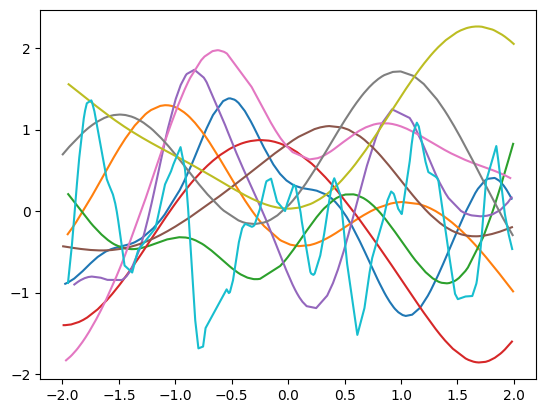

In [10]:
X_1, Y_1 = test_one_d_datasets[0]
X_2, Y_2 = test_one_d_datasets[1]
X_3, Y_3 = test_one_d_datasets[2]
X_4, Y_4 = test_one_d_datasets[3]
X_5, Y_5 = test_one_d_datasets[4]
X_6, Y_6 = test_one_d_datasets[5]
X_7, Y_7 = test_one_d_datasets[6]
X_8, Y_8 = test_one_d_datasets[7]
X_9, Y_9 = test_one_d_datasets[8]
X_10, Y_10 = test_one_d_datasets[9]



plt.plot(X_1, Y_1)
plt.plot(X_2, Y_2)
plt.plot(X_3, Y_3)
plt.plot(X_4, Y_4)
plt.plot(X_5, Y_5)
plt.plot(X_6, Y_6)
plt.plot(X_7, Y_7)
plt.plot(X_8, Y_8)
plt.plot(X_9, Y_9)
plt.plot(X_10, Y_10)


In [5]:
from architecture_classes import *
from utils import *
import torch


class ConditionalNeuralProcess(torch.nn.Module):
    """
    Class defining conditional neural processes for regression problems with arbitrary X-dimension

    Parameters
    ----------

    encoder: module, MLP
    decoder: module, MLP
    last_decoder_layer_dim: output of last decoder layer
    y_dim: output_dimension, int

    """

    def __init__(self, encoder, decoder,last_decoder_layer_dim, y_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.lastLayer_mu = torch.nn.Linear(last_decoder_layer_dim, y_dim)
        self.lastLayer_log_var = torch.nn.Linear(last_decoder_layer_dim, y_dim)
        

    def forward(self, context_x, context_y, target_x, target_y = None):
        full_context = torch.concat([context_x, context_y], dim=-1)

        encoder_output = self.encoder(full_context)
        encoder_output = torch.mean(encoder_output, dim=1)

        encoder_output = encoder_output.unsqueeze(dim=1).tile((1,target_x.shape[1],1))

        decoder_input = torch.concat([target_x, encoder_output], dim=-1)

        decoder_output = self.decoder(decoder_input)

        prediction_mu = self.lastLayer_mu(decoder_output)
        prediction_log_var = self.lastLayer_log_var(decoder_output)

        prediction_var = 0.1 + 0.9*torch.exp(prediction_log_var/2)

        if target_y is not None:

            p_y_target = torch.distributions.Normal(prediction_mu, prediction_var)
            log_likelihood = p_y_target.log_prob(target_y).mean(dim=0).sum()
            return prediction_mu, prediction_var, -log_likelihood
            
        else:
            
            return prediction_mu, prediction_var

In [6]:
MLP.__doc__

In [7]:
encoder = MLP(2,[128,128,128,128])
decoder = MLP(129,[128,128,128,128])

one_d_cnp = ConditionalNeuralProcess(encoder, decoder, 128,1)

In [8]:
dloader = torch.utils.data.DataLoader(dataset= test_one_d_datasets, batch_size=32, shuffle=True)

In [9]:
for batch in dloader:
    break
    

In [10]:
from utils import *

In [11]:
batch[0].shape

torch.Size([32, 128])

In [211]:
X.shape

torch.Size([32, 128])

In [12]:
min_context = int(batch[0].shape[1]*0.1)
max_context = int(batch[0].shape[1]*0.9)
len_seq = int(batch[0].shape[1])

(((X_context, Y_context), X_target), Y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)

In [13]:
from tqdm import tqdm
from tensorboardX import SummaryWriter


EPOCHS=50
one_d_cnp.train()
optim = torch.optim.Adam(one_d_cnp.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(test_one_d_datasets, batch_size=32, shuffle=True)
    for i, batch in tqdm(enumerate(loader)):
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
        #adjust_learning_rate(optim, global_step)
        
        y_pred_mu,y_pred_var, loss = one_d_cnp(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    print(loss)

313it [00:13, 22.59it/s]


tensor(132.5526, grad_fn=<NegBackward0>)


313it [00:13, 23.21it/s]


tensor(102.4432, grad_fn=<NegBackward0>)


313it [00:13, 23.29it/s]


tensor(74.8209, grad_fn=<NegBackward0>)


313it [00:13, 23.12it/s]


tensor(63.0685, grad_fn=<NegBackward0>)


313it [00:13, 23.21it/s]


tensor(42.7811, grad_fn=<NegBackward0>)


313it [00:15, 20.17it/s]


tensor(94.9354, grad_fn=<NegBackward0>)


313it [00:14, 22.34it/s]


tensor(36.3371, grad_fn=<NegBackward0>)


313it [00:14, 21.13it/s]


tensor(-19.9060, grad_fn=<NegBackward0>)


313it [00:14, 21.69it/s]


tensor(102.2810, grad_fn=<NegBackward0>)


313it [00:15, 20.11it/s]


tensor(51.4450, grad_fn=<NegBackward0>)


313it [00:14, 22.19it/s]


tensor(10.2178, grad_fn=<NegBackward0>)


313it [00:14, 21.92it/s]


tensor(54.5021, grad_fn=<NegBackward0>)


313it [00:14, 21.98it/s]


tensor(17.6239, grad_fn=<NegBackward0>)


313it [00:14, 21.50it/s]


tensor(50.5033, grad_fn=<NegBackward0>)


313it [00:14, 21.82it/s]


tensor(23.6471, grad_fn=<NegBackward0>)


313it [00:14, 21.53it/s]


tensor(43.2214, grad_fn=<NegBackward0>)


313it [00:14, 21.93it/s]


tensor(25.7455, grad_fn=<NegBackward0>)


313it [00:14, 21.21it/s]


tensor(-13.9062, grad_fn=<NegBackward0>)


313it [00:14, 21.29it/s]


tensor(-23.6543, grad_fn=<NegBackward0>)


313it [00:14, 21.89it/s]


tensor(51.1643, grad_fn=<NegBackward0>)


313it [00:15, 20.72it/s]


tensor(35.7885, grad_fn=<NegBackward0>)


313it [00:14, 21.61it/s]


tensor(-19.7637, grad_fn=<NegBackward0>)


313it [00:14, 22.27it/s]


tensor(60.1592, grad_fn=<NegBackward0>)


313it [00:15, 20.09it/s]


tensor(111.4902, grad_fn=<NegBackward0>)


313it [00:14, 22.25it/s]


tensor(-24.6465, grad_fn=<NegBackward0>)


313it [00:13, 22.50it/s]


tensor(39.8401, grad_fn=<NegBackward0>)


313it [00:16, 19.43it/s]


tensor(24.0044, grad_fn=<NegBackward0>)


313it [00:14, 22.24it/s]


tensor(34.1375, grad_fn=<NegBackward0>)


313it [00:13, 22.77it/s]


tensor(-3.1581, grad_fn=<NegBackward0>)


313it [00:14, 21.18it/s]


tensor(70.9392, grad_fn=<NegBackward0>)


313it [00:14, 21.17it/s]


tensor(111.2660, grad_fn=<NegBackward0>)


313it [00:16, 18.56it/s]


tensor(-21.6366, grad_fn=<NegBackward0>)


313it [00:13, 22.56it/s]


tensor(21.9296, grad_fn=<NegBackward0>)


313it [00:13, 22.60it/s]


tensor(-37.9281, grad_fn=<NegBackward0>)


313it [00:14, 21.51it/s]


tensor(-8.7886, grad_fn=<NegBackward0>)


313it [00:13, 22.51it/s]


tensor(-50.7104, grad_fn=<NegBackward0>)


313it [00:14, 22.20it/s]


tensor(-13.8717, grad_fn=<NegBackward0>)


313it [00:14, 22.32it/s]


tensor(-17.5682, grad_fn=<NegBackward0>)


313it [00:14, 21.20it/s]


tensor(-14.5205, grad_fn=<NegBackward0>)


313it [00:14, 21.85it/s]


tensor(42.6000, grad_fn=<NegBackward0>)


313it [00:13, 22.56it/s]


tensor(-28.0894, grad_fn=<NegBackward0>)


313it [00:13, 22.60it/s]


tensor(-0.2735, grad_fn=<NegBackward0>)


313it [00:14, 22.29it/s]


tensor(-18.9383, grad_fn=<NegBackward0>)


313it [00:14, 21.95it/s]


tensor(-11.6628, grad_fn=<NegBackward0>)


313it [00:13, 22.57it/s]


tensor(-9.5787, grad_fn=<NegBackward0>)


313it [00:13, 22.82it/s]


tensor(-65.4481, grad_fn=<NegBackward0>)


313it [00:15, 20.52it/s]


tensor(28.4328, grad_fn=<NegBackward0>)


313it [00:15, 20.79it/s]


tensor(-27.8763, grad_fn=<NegBackward0>)


313it [00:14, 21.53it/s]


tensor(35.4127, grad_fn=<NegBackward0>)


313it [00:13, 22.46it/s]

tensor(-41.6821, grad_fn=<NegBackward0>)


In [169]:
for i, batch in tqdm(enumerate(loader)):
        
    #global_step+=1
    (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
    break

0it [00:00, ?it/s]


In [170]:
mu, var, likelihood = one_d_cnp(x_context, y_context, x_target, y_target)

In [171]:
mu.shape

torch.Size([32, 128, 1])

In [172]:
X, Y = batch

In [176]:
var.detach().numpy()[1]

array([[0.17557642],
       [0.29102543],
       [0.16719854],
       [0.18447839],
       [0.1885558 ],
       [0.15222767],
       [0.16774908],
       [0.2819066 ],
       [0.19344184],
       [0.27510706],
       [0.17154887],
       [0.2126705 ],
       [0.28238097],
       [0.22977251],
       [0.21328272],
       [0.16345209],
       [0.1853388 ],
       [0.1623535 ],
       [0.2919467 ],
       [0.43638363],
       [0.17544883],
       [0.18538836],
       [0.17262137],
       [0.21897721],
       [0.1529966 ],
       [0.16025054],
       [0.29526463],
       [0.19141233],
       [0.15224722],
       [0.23650831],
       [0.27058324],
       [0.22452986],
       [0.34837708],
       [0.19101822],
       [0.1934185 ],
       [0.15496537],
       [0.19441104],
       [0.17804557],
       [0.16076815],
       [0.27061376],
       [0.17056651],
       [0.21730782],
       [0.2668576 ],
       [0.15537103],
       [0.20486948],
       [0.15920135],
       [0.19100666],
       [0.158

In [182]:
(mu.detach().numpy()[1]-var.detach().numpy()[1]).reshape(128,)

array([ 2.0552742 , -0.37549967,  1.1335652 ,  1.4157851 ,  1.473809  ,
        1.6562665 ,  1.022675  , -0.39181116,  0.8061539 ,  0.06255803,
        0.8456936 ,  0.72622067, -0.02519497,  1.452662  ,  0.5183983 ,
        0.8578848 ,  1.4283421 ,  0.8593168 , -0.3368014 ,  0.15559635,
        1.2493672 ,  0.8373064 ,  1.2207282 ,  1.471851  ,  1.759893  ,
        0.8407397 ,  0.27865288,  0.7854787 ,  1.6611282 ,  1.8544056 ,
       -0.44188872,  1.8934242 , -0.55375504,  1.5312934 ,  0.8026949 ,
        1.868442  ,  0.97326183,  1.3152754 ,  1.4464105 , -0.3998016 ,
        1.2448841 ,  1.9187515 , -0.41078007,  1.9044079 ,  1.4998455 ,
        2.1225293 ,  1.5312967 ,  1.4725461 ,  0.75524986,  1.7765019 ,
        0.8265416 ,  1.3493004 ,  2.017856  ,  1.0276463 ,  0.9205544 ,
        0.8737879 ,  1.4495307 ,  2.0534115 , -0.5055543 ,  1.0745367 ,
        1.6100266 ,  0.85627127,  0.7696424 ,  0.7798436 , -0.07600802,
        1.8670268 ,  1.0268745 , -0.24384008, -0.37777904,  1.91

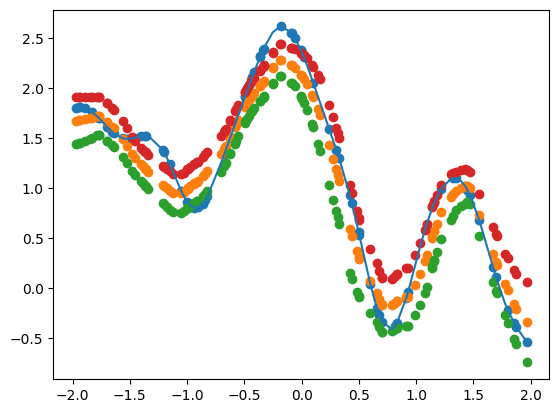

In [185]:
plt.plot(X[1], Y[1])
plt.scatter(x_context[1], y_context[1])

plt.scatter(x_target[1], mu.detach().numpy()[1])
plt.scatter(x_target[1].squeeze(), (mu.detach().numpy()[1]-var.detach().numpy()[1]).reshape(128,))
plt.scatter(x_target[1], (mu.detach().numpy()[1]+var.detach().numpy()[1]).reshape(128,))


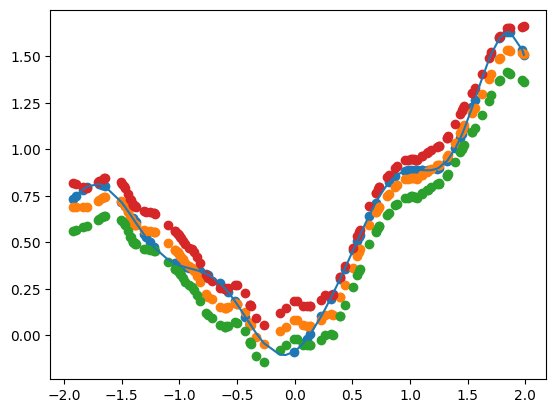

In [188]:
plt.plot(X[3], Y[3])
plt.scatter(x_context[3], y_context[3])

plt.scatter(x_target[3], mu.detach().numpy()[3])
plt.scatter(x_target[3].squeeze(), (mu.detach().numpy()[3]-var.detach().numpy()[3]).reshape(128,))
plt.scatter(x_target[3], (mu.detach().numpy()[3]+var.detach().numpy()[3]).reshape(128,))


In [83]:
encoder_output = one_d_cnp.encoder(torch.concat([X_context, Y_context], dim=-1))

In [84]:
encoder_output.shape

torch.Size([32, 101, 128])

In [85]:
encoder_output = torch.mean(encoder_output, dim=1)

encoder_output = encoder_output.unsqueeze(dim=1).tile((1,X_target.shape[1],1))

decoder_input = torch.concat([X_target, encoder_output], dim=-1)

decoder_output = one_d_cnp.decoder(decoder_input)

prediction_mu = one_d_cnp.lastLayer_mu(decoder_output)
prediction_log_var = one_d_cnp.lastLayer_log_var(decoder_output)

In [88]:
prediction_mu.shape

torch.Size([32, 27, 1])

In [89]:
prediction_var = 0.1 + 0.9*torch.exp(prediction_log_var/2)

In [90]:
prediction_var

tensor([[[0.9820],
         [0.9824],
         [0.9825],
         [0.9824],
         [0.9826],
         [0.9825],
         [0.9825],
         [0.9823],
         [0.9823],
         [0.9824],
         [0.9826],
         [0.9826],
         [0.9822],
         [0.9824],
         [0.9813],
         [0.9808],
         [0.9820],
         [0.9825],
         [0.9824],
         [0.9824],
         [0.9824],
         [0.9825],
         [0.9825],
         [0.9825],
         [0.9824],
         [0.9825],
         [0.9823]],

        [[0.9805],
         [0.9810],
         [0.9823],
         [0.9809],
         [0.9824],
         [0.9825],
         [0.9819],
         [0.9826],
         [0.9826],
         [0.9825],
         [0.9825],
         [0.9824],
         [0.9826],
         [0.9825],
         [0.9817],
         [0.9825],
         [0.9824],
         [0.9821],
         [0.9822],
         [0.9818],
         [0.9826],
         [0.9826],
         [0.9824],
         [0.9823],
         [0.9823],
         [

In [110]:
prediction_mu_reshaped = prediction_mu.reshape((prediction_mu.shape[0]*prediction_mu.shape[1],1))
prediction_var_reshaped = prediction_var.reshape((prediction_var.shape[0]* prediction_var.shape[1],1))

p_y_target = torch.distributions.Normal(prediction_mu, prediction_var)
log_likelihood = p_y_target.log_prob(Y_target).mean(dim=0).sum()

In [111]:
log_likelihood

tensor(-35.8384, grad_fn=<SumBackward0>)

In [106]:
A = torch.eye(3)
b = torch.tensor([1.0, 2.0, 3.0])


RuntimeError: einsum(): invalid subscript given at index 1 in the equation string, subscripts must be in [a-zA-Z]

In [102]:
torch.diag(prediction_var_reshaped)

tensor([0.9820], grad_fn=<DiagonalBackward0_copy>)

In [92]:
prediction_mu_reshaped.shape

torch.Size([864, 1])

In [93]:
prediction_var_reshaped.shape

torch.Size([864, 1])

In [99]:
mask = torch.diag(torch.ones_like(prediction_var_reshaped))
out = mask*prediction_var_reshaped

In [101]:
out.shape

torch.Size([864, 1])

In [98]:
prediction_var_reshaped

tensor([[0.9820],
        [0.9824],
        [0.9825],
        [0.9824],
        [0.9826],
        [0.9825],
        [0.9825],
        [0.9823],
        [0.9823],
        [0.9824],
        [0.9826],
        [0.9826],
        [0.9822],
        [0.9824],
        [0.9813],
        [0.9808],
        [0.9820],
        [0.9825],
        [0.9824],
        [0.9824],
        [0.9824],
        [0.9825],
        [0.9825],
        [0.9825],
        [0.9824],
        [0.9825],
        [0.9823],
        [0.9805],
        [0.9810],
        [0.9823],
        [0.9809],
        [0.9824],
        [0.9825],
        [0.9819],
        [0.9826],
        [0.9826],
        [0.9825],
        [0.9825],
        [0.9824],
        [0.9826],
        [0.9825],
        [0.9817],
        [0.9825],
        [0.9824],
        [0.9821],
        [0.9822],
        [0.9818],
        [0.9826],
        [0.9826],
        [0.9824],
        [0.9823],
        [0.9823],
        [0.9807],
        [0.9826],
        [0.9824],
        [0

In [189]:
val_one_d_datasets = One_D_Datasets()
val_one_d_datasets.get_samples(None, None, None)

(array([[-1.99587282, -1.98548029, -1.95537987, ...,  1.97257414,
          1.99169953,  1.99881194],
        [-1.94339652, -1.91990806, -1.76699714, ...,  1.91765172,
          1.94336445,  1.96462939],
        [-1.96199672, -1.9437505 , -1.91827439, ...,  1.80033871,
          1.84551921,  1.85723317],
        ...,
        [-1.94011869, -1.93410148, -1.8983857 , ...,  1.93203934,
          1.95185246,  1.97395395],
        [-1.96401548, -1.95896315, -1.88993095, ...,  1.93615654,
          1.96021198,  1.96555438],
        [-1.91719145, -1.87583723, -1.82759331, ...,  1.84556681,
          1.90916498,  1.92599152]]),
 tensor([[[ 0.5635],
          [ 0.6170],
          [ 0.7449],
          ...,
          [-1.8718],
          [-1.6952],
          [-1.6259]],
 
         [[ 0.4168],
          [ 0.4412],
          [ 0.6575],
          ...,
          [ 0.2367],
          [ 0.2131],
          [ 0.1908]],
 
         [[ 0.7703],
          [ 0.7853],
          [ 0.8063],
          ...,
       

In [190]:
dloader = torch.utils.data.DataLoader(dataset= val_one_d_datasets, batch_size=32, shuffle=True)

In [191]:
for i, batch in tqdm(enumerate(dloader)):
        
    #global_step+=1
    (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
    break

0it [00:00, ?it/s]


In [192]:
mu, var, likelihood = one_d_cnp(x_context, y_context, x_target, y_target)

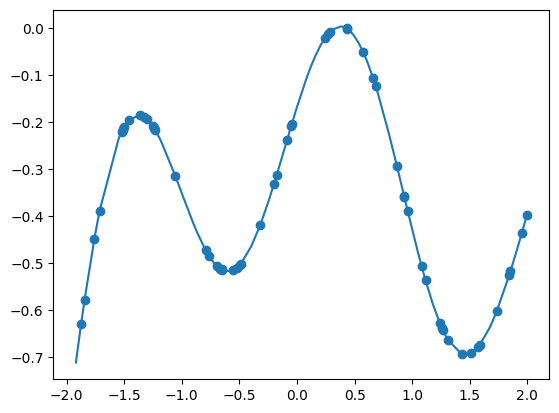

In [207]:
plt.plot(X[20], Y[20])
plt.scatter(x_context[20], y_context[20])

#plt.scatter(x_target[1], mu.detach().numpy()[1])
#plt.scatter(x_target[1].squeeze(), (mu.detach().numpy()[1]-var.detach().numpy()[1]).reshape(128,))
#plt.scatter(x_target[1], (mu.detach().numpy()[1]+var.detach().numpy()[1]).reshape(128,))

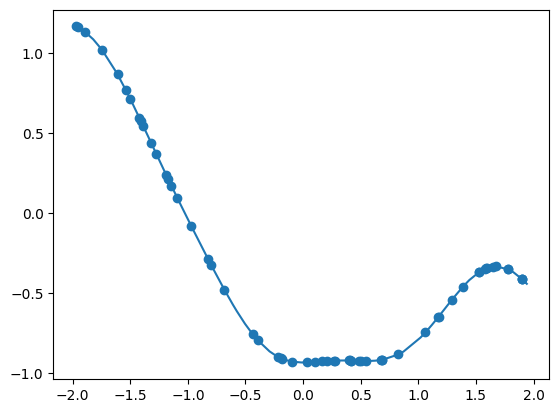

In [208]:
plt.plot(X[10], Y[10])
plt.scatter(x_context[10], y_context[10])

#plt.scatter(x_target[1], mu.detach().numpy()[1])
#plt.scatter(x_target[1].squeeze(), (mu.detach().numpy()[1]-var.detach().numpy()[1]).reshape(128,))
#plt.scatter(x_target[1], (mu.detach().numpy()[1]+var.detach().numpy()[1]).reshape(128,))

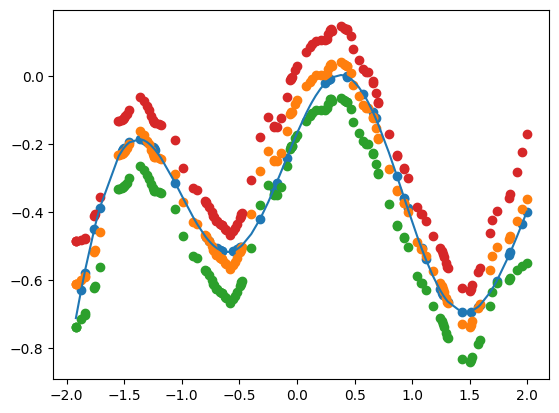

In [204]:
plt.plot(X[20], Y[20])
plt.scatter(x_context[20], y_context[20])

plt.scatter(x_target[20], mu.detach().numpy()[20])
plt.scatter(x_target[20].squeeze(), (mu.detach().numpy()[20]-var.detach().numpy()[20]).reshape(128,))
plt.scatter(x_target[20], (mu.detach().numpy()[20]+var.detach().numpy()[20]).reshape(128,))